In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import datetime
import os
import re
from collections import Counter
from datetime import datetime

import numpy as np
from keras.preprocessing import sequence

In [3]:
sensor_codes = ['M001', 'M002', 'M003', 'M004', 'M005', 'M006', 'M007', 
                'M008', 'M009', 'M010', 'M011', 'M012', 'M013', 'M014',
                'M015', 'M016', 'M017', 'M018', 'M019', 'M020', 'M021', 
                'M022', 'M023', 'M024', 'M025', 'M026', 'M027', 'M028',
                'M029', 'M030', 'D001', 'D002', 'D003', 'D004', 'T001',
                'T002', 'T003', 'T004', 'T005']

In [4]:
def load_dataset(filename):
    # dateset fields
    timestamps = []
    sensors = []
    values = []
    activities = []

    current_activity = ''  # empty

    with open(filename, 'rb') as features:
        database = features.readlines()
        
        for i, line in enumerate(database):  # each line
            f_info = line.decode().split()  # find fields
            try:
                if 'M' == f_info[2][0] or 'D' == f_info[2][0] or 'T' == f_info[2][0]:
                    if str(np.array(f_info[2])) in sensor_codes:
                        sensors.append(str(np.array(f_info[2])))
                    else:
                        continue
                       
                    if 'OFF' in f_info[3]:
                        values.append('OFF')
                    elif 'ON' in f_info[3]:
                        values.append('ON')
                    else:
                        try:
                            values.append(float(str(np.array(f_info[3]))))
                        except ValueError:
                            del sensors[-1]
                            continue
                            
                    # choose only M D T sensors, avoiding unexpected errors
                    if not ('.' in str(np.array(f_info[0])) + str(np.array(f_info[1]))):
                        f_info[1] = f_info[1] + '.000000'
                        
                    try:
                        timestamps.append(datetime.strptime(str(np.array(f_info[0])) + str(np.array(f_info[1])),
                                                        "%Y-%m-%d%H:%M:%S.%f"))
                    except ValueError:
                        del sensors[-1]
                        del values[-1]
                        continue
                        
                    if len(f_info) == 4:  # if activity does not exist
                        activities.append(current_activity)
                    else:  # if activity exists
                        des = str(' '.join(np.array(f_info[4:])))
                        if 'begin' in des:
                            current_activity = re.sub('begin', '', des)
                            if current_activity[-1] == ' ':  # if white space at the end
                                current_activity = current_activity[:-1]  # delete white space
                            activities.append(current_activity)
                        if 'end' in des:
                            activities.append(current_activity)
                            current_activity = ''
            except IndexError:
                print(i, line)
                
    features.close()
    # dictionaries: assigning keys to values
    temperature = []
    for element in values:
        try:
            temperature.append(float(element))
        except ValueError:
            pass
    
    return timestamps, sensors, values, activities, temperature

In [10]:
def AssignKeysToValues(timestamps, sensors, values, activities, temperature):
    
    for i in range(0, len(values)):
        values[i] = str(values[i]) ##VALUES TO STR
    
    sensorsList = sorted(set(sensors))
    dictSensors = {}
    for i, sensor in enumerate(sensorsList):
        dictSensors[sensor] = i
    activityList = sorted(set(activities))
    dictActivities = {}
    for i, activity in enumerate(activityList):
        dictActivities[activity] = i
    valueList = sorted(set(values))
    dictValues = {}
    for i, v in enumerate(valueList):
        dictValues[v] = i
    dictObs = {}
    count = 0
    for key in dictSensors.keys():
        if "M" or "AD" in key:
            dictObs[key + "OFF"] = count
            count += 1
            dictObs[key + "ON"] = count
            count += 1
        if "D" in key:
            dictObs[key + "CLOSE"] = count
            count += 1
            dictObs[key + "OPEN"] = count
            count += 1
        if "T" in key:
            for temp in range(0, int((max(temperature) - min(temperature)) * 2) + 1):
                dictObs[key + str(float(temp / 2.0) + min(temperature))] = count + temp

    XX = []
    YY = []
    X = []
    Y = []
    for kk, s in enumerate(sensors):
        if "T" in s:
            try:
                XX.append(dictObs[s + str(round(float(values[kk]), 1))])
            except Exception:
                if len(XX) > 0:
                    XX.append(XX[-1])
                else:
                    XX.append(0)
                
        else:
            try:
                XX.append(dictObs[s + str(values[kk])])
            except Exception:
                if len(XX) > 0:
                    XX.append(XX[-1])
                else:
                    XX.append(0)
        YY.append(dictActivities[activities[kk]])

    x = []
    for i, y in enumerate(YY):
        if i == 0:
            Y.append(y)
            x = [XX[i]]
        if i > 0:
            if y == YY[i - 1]:
                x.append(XX[i])
            else:
                Y.append(y)
                X.append(x)
                x = [XX[i]]
        if i == len(YY) - 1:
            if y != YY[i - 1]:
                Y.append(y)
            X.append(x)
    return X, Y, dictActivities

In [5]:
def add_transition_labels(aruba_set):
    new_activity = ''
    previous_activity = ''
    
    for i, entry in enumerate(aruba_set[3]): 
        if entry == '':
            if new_activity != '':
                aruba_set[3][i] = new_activity
            else:
                for next_entry in aruba_set[3][i:]:
                    if next_entry != '':
                        new_activity = 'Transition_' + previous_activity + '_' + next_entry
                        aruba_set[3][i] = new_activity
                        break            
        else:
            previous_activity = entry
            new_activity = ''
    return aruba_set

In [6]:
aruba_dataset = load_dataset("./datasets/aruba/data")

In [7]:
aruba_dataset = add_transition_labels(aruba_dataset)

In [8]:
len(aruba_dataset[0]), len(aruba_dataset[1]), len(aruba_dataset[2]), len(aruba_dataset[3]), len(aruba_dataset[0])

(1709857, 1709857, 1709857, 1709857, 1709857)

In [26]:
X, Y, dictActivities = AssignKeysToValues(aruba_dataset[0], aruba_dataset[1], aruba_dataset[2], aruba_dataset[3], aruba_dataset[4])

In [27]:
dictActivities

{'Bed_to_Toilet': 0,
 'Eating': 1,
 'Enter_Home': 2,
 'Housekeeping': 3,
 'Leave_Home': 4,
 'Meal_Preparation': 5,
 'Relax': 6,
 'Respirate': 7,
 'Sleeping': 8,
 'Transition_Bed_to_Toilet_Bed_to_Toilet': 9,
 'Transition_Bed_to_Toilet_Meal_Preparation': 10,
 'Transition_Bed_to_Toilet_Sleeping': 11,
 'Transition_Eating_Eating': 12,
 'Transition_Eating_Enter_Home': 13,
 'Transition_Eating_Meal_Preparation': 14,
 'Transition_Eating_Relax': 15,
 'Transition_Eating_Sleeping': 16,
 'Transition_Eating_Wash_Dishes': 17,
 'Transition_Eating_Work': 18,
 'Transition_Enter_Home_Relax': 19,
 'Transition_Leave_Home_Meal_Preparation': 20,
 'Transition_Meal_Preparation_Eating': 21,
 'Transition_Meal_Preparation_Leave_Home': 22,
 'Transition_Meal_Preparation_Meal_Preparation': 23,
 'Transition_Meal_Preparation_Relax': 24,
 'Transition_Meal_Preparation_Respirate': 25,
 'Transition_Meal_Preparation_Work': 26,
 'Transition_Relax_Eating': 27,
 'Transition_Relax_Enter_Home': 28,
 'Transition_Relax_Housekeepi

In [28]:
len(X), len(Y), len(dictActivities)

(11056, 11056, 57)

In [29]:
X_padded_2000 = sequence.pad_sequences(X, maxlen=2000, dtype='int32')

In [30]:
#delete labels that appear only once
mp = {}
for i in range(0, len(Y)):
    mp[str(Y[i])] = 0

for i in range(0, len(Y)):
    mp[str(Y[i])] += 1
    
print(mp)
LEN = len(Y)
i = 0
while i < LEN:
    if mp[str(Y[i])] <= 1:
        for x in dictActivities.keys():
            if dictActivities[x] == Y[i]: 
                del dictActivities[x]
                break
        Y = np.delete(Y, i)
        X_padded_2000 = np.delete(X_padded_2000, i, axis=0)
        LEN -= 1
        
    else:
        i += 1


{'8': 401, '39': 132, '0': 157, '11': 145, '40': 211, '5': 1606, '23': 623, '24': 731, '6': 2918, '31': 621, '21': 167, '1': 257, '12': 31, '17': 36, '55': 65, '45': 48, '18': 13, '56': 171, '50': 64, '27': 17, '47': 7, '52': 5, '26': 26, '54': 42, '36': 82, '29': 3, '3': 4, '43': 1, '15': 105, '32': 1921, '14': 57, '49': 54, '48': 3, '34': 223, '46': 1, '42': 16, '25': 1, '7': 6, '38': 4, '16': 2, '33': 4, '44': 8, '35': 23, '41': 18, '28': 3, '2': 5, '19': 1, '9': 2, '13': 2, '30': 1, '4': 3, '20': 1, '22': 2, '53': 2, '51': 1, '37': 2, '10': 1}


In [34]:
values = sorted(mp.values())



[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 13, 16, 17, 18, 23, 26, 31, 36, 42, 48, 54, 57, 64, 65, 82, 105, 132, 145, 157, 167, 171, 211, 223, 257, 401, 621, 623, 731, 1606, 1921, 2918]


In [ ]:
Relax : 2918
Transition_Relax_to_Relax:1921
Meal_Preparation:1606
        
    -----
   'Transition_Leave_Home_Meal_Preparation' :1
   'Transition_Meal_Preparation_Respirate' :1
   'Transition_Relax_Leave_Home':1


In [23]:
xxx = []
yyy = []
for keys in mp.keys():
    xxx.append(keys)
    yyy.append(mp[keys])
    



<BarContainer object of 57 artists>

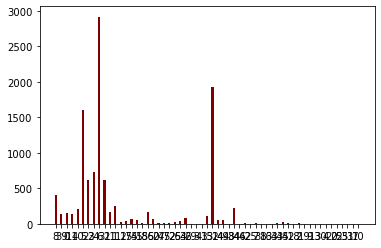

In [24]:
plt.bar(xxx, yyy, color ='maroon',
        width = 0.4)

In [47]:
len(X_padded_2000), len(Y), len(dictActivities)

(11048, 11048, 49)

In [17]:
mp = {}
for i in range(0, len(Y)):
    mp[str(Y[i])] = 0

for i in range(0, len(Y)):
    mp[str(Y[i])] += 1


In [49]:
dictActivities

{'Bed_to_Toilet': 0,
 'Eating': 1,
 'Enter_Home': 2,
 'Housekeeping': 3,
 'Leave_Home': 4,
 'Meal_Preparation': 5,
 'Relax': 6,
 'Respirate': 7,
 'Sleeping': 8,
 'Transition_Bed_to_Toilet_Bed_to_Toilet': 9,
 'Transition_Bed_to_Toilet_Sleeping': 11,
 'Transition_Eating_Eating': 12,
 'Transition_Eating_Enter_Home': 13,
 'Transition_Eating_Meal_Preparation': 14,
 'Transition_Eating_Relax': 15,
 'Transition_Eating_Sleeping': 16,
 'Transition_Eating_Wash_Dishes': 17,
 'Transition_Eating_Work': 18,
 'Transition_Meal_Preparation_Eating': 21,
 'Transition_Meal_Preparation_Leave_Home': 22,
 'Transition_Meal_Preparation_Meal_Preparation': 23,
 'Transition_Meal_Preparation_Relax': 24,
 'Transition_Meal_Preparation_Work': 26,
 'Transition_Relax_Eating': 27,
 'Transition_Relax_Enter_Home': 28,
 'Transition_Relax_Housekeeping': 29,
 'Transition_Relax_Meal_Preparation': 31,
 'Transition_Relax_Relax': 32,
 'Transition_Relax_Respirate': 33,
 'Transition_Relax_Sleeping': 34,
 'Transition_Relax_Wash_Dish

In [53]:
len(dictActivities)

49

In [52]:
#reArrange activities from 0 to 48
newAcList = []

for x in dictActivities.keys():
    newAcList.append(x)
    
aux = {}
for i, activity in enumerate(newAcList):
    for j in range(0, len(Y)):
        if Y[j] == dictActivities[activity]:
            Y[j] = i
    dictActivities[activity] = i

In [ ]:
np.save('X_LSTM.npy', X_padded_2000)
np.save('y_LSTM.npy', Y)
np.save('Labels_LSTM.npy', dictActivities)

In [67]:
X = np.load('X_LSTM.npy', allow_pickle=True)
Y = np.load('y_LSTM.npy')
dictActivities = np.load('Labels_LSTM.npy', allow_pickle=True).item()

In [56]:
dictActivities

{'Bed_to_Toilet': 0,
 'Eating': 1,
 'Enter_Home': 2,
 'Housekeeping': 3,
 'Leave_Home': 4,
 'Meal_Preparation': 5,
 'Relax': 6,
 'Respirate': 7,
 'Sleeping': 8,
 'Transition_Bed_to_Toilet_Bed_to_Toilet': 9,
 'Transition_Bed_to_Toilet_Sleeping': 10,
 'Transition_Eating_Eating': 11,
 'Transition_Eating_Enter_Home': 12,
 'Transition_Eating_Meal_Preparation': 13,
 'Transition_Eating_Relax': 14,
 'Transition_Eating_Sleeping': 15,
 'Transition_Eating_Wash_Dishes': 16,
 'Transition_Eating_Work': 17,
 'Transition_Meal_Preparation_Eating': 18,
 'Transition_Meal_Preparation_Leave_Home': 19,
 'Transition_Meal_Preparation_Meal_Preparation': 20,
 'Transition_Meal_Preparation_Relax': 21,
 'Transition_Meal_Preparation_Work': 22,
 'Transition_Relax_Eating': 23,
 'Transition_Relax_Enter_Home': 24,
 'Transition_Relax_Housekeeping': 25,
 'Transition_Relax_Meal_Preparation': 26,
 'Transition_Relax_Relax': 27,
 'Transition_Relax_Respirate': 28,
 'Transition_Relax_Sleeping': 29,
 'Transition_Relax_Wash_Dish

In [57]:
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.utils import compute_class_weight
from keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

In [58]:
def get_LSTM(input_dim, output_dim, max_lenght, no_activities):
    model = Sequential(name='LSTM')
    model.add(Embedding(input_dim, output_dim, input_length=max_lenght, mask_zero=True))
    model.add(LSTM(output_dim))
    model.add(Dense(no_activities, activation='softmax'))
    return model

In [59]:
def compileModel(model):
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [74]:
# fix random seed for reproducibility
seed = 7
units = 64
epochs = 100

In [63]:
import argparse
import csv
from datetime import datetime

In [68]:
len(X)

11048

In [75]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
k = 0

In [76]:
dataset="aruba"
cvaccuracy = []
cvscores = []

for train, test in kfold.split(X, Y):
    input_dim = len(X[train])
    X_train_input = X[train]
    X_test_input = X[test]
    no_activities = len(dictActivities)

    model = get_LSTM(input_dim, units, 2000, no_activities)
    model = compileModel(model)

    modelname = "LSTM"
    currenttime = datetime.utcnow().strftime('%Y%m%d-%H%M%S')

    csv_logger = CSVLogger(
    model.name + '-' + dataset + '-' + str(currenttime) + '.csv')
    model_checkpoint = ModelCheckpoint(
    model.name + '-' + dataset + '-' + str(currenttime) + '.h5',
    monitor='acc',
    save_best_only=True)

    # train the model
    print('Begin training ...')
    # class_weight = compute_class_weight('balanced', np.unique(Y),
    #                                             Y)  # use as optional argument in the fit function

    model.fit(X_train_input, Y[train], validation_split=0.2, epochs=epochs, batch_size=64, verbose=1,
          callbacks=[csv_logger, model_checkpoint])

    # evaluate the model
    print('Begin testing ...')
    scores = model.evaluate(X_test_input, Y[test], batch_size=64, verbose=1)
    print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))

    print('Report:')
    target_names = sorted(dictActivities, key=dictActivities.get)

    predict_x = model.predict(X)
    classes=np.argmax(predict_x,axis=-1)

    print(classification_report(list(Y), classes, target_names=target_names))
    print('Confusion matrix:')
    labels = list(dictActivities.values())
    print(confusion_matrix(list(Y), classes, labels=labels))

    cvaccuracy.append(scores[1] * 100)
    cvscores.append(scores)

    k += 1

print('{:.2f}% (+/- {:.2f}%)'.format(np.mean(cvaccuracy), np.std(cvaccuracy)))

currenttime = datetime.utcnow().strftime('%Y%m%d-%H%M%S')
csvfile = 'cv-scores-' + modelname + '-' + dataset + '-' + str(currenttime) + '.csv'

with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in cvscores:
        writer.writerow([",".join(str(el) for el in val)])


Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 2000, 64)          353536    
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 49)                3185      
                                                                 
Total params: 389,745
Trainable params: 389,745
Non-trainable params: 0
_________________________________________________________________
None
Begin training ...
Epoch 1/100
10/70 [===>..........................] - ETA: 58s - loss: 3.8396 - accuracy: 0.2500

KeyboardInterrupt: 

In [15]:
model.evaluate(X, Y)

346/346 [==============================] - 77s 222ms/step - loss: 0.3312 - accuracy: 0.9332


[0.33119869232177734, 0.9331584572792053]

In [50]:
model.save('my_model.h5')

In [52]:
from keras.models import load_model

In [53]:
model_test = load_model('my_model.h5')
